### Step 1: Import Libraries

In [1]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')


### Step 2: Load the Dataset

In [3]:
# Step 2: Load the Dataset
df = pd.read_csv('stocks.csv')  # Already uploaded

# Preview the data
df.head()


,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,AAPL,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
2,AAPL,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
3,AAPL,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57450700
4,AAPL,2023-02-13,150.949997,154.259995,150.919998,153.850006,153.850006,62199000


### Step 3: Data Overview

In [4]:
# Step 3: Data Overview
print(df.shape)
print(df.info())
print(df.describe())


(248, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     248 non-null    object 
 1   Date       248 non-null    object 
 2   Open       248 non-null    float64
 3   High       248 non-null    float64
 4   Low        248 non-null    float64
 5   Close      248 non-null    float64
 6   Adj Close  248 non-null    float64
 7   Volume     248 non-null    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 15.6+ KB
None
             Open        High         Low       Close   Adj Close  \
count  248.000000  248.000000  248.000000  248.000000  248.000000   
mean   215.252093  217.919662  212.697452  215.381674  215.362697   
std     91.691315   92.863023   90.147881   91.461989   91.454750   
min     89.540001   90.129997   88.860001   89.349998   89.349998   
25%    135.235004  137.440004  134.822495  136.347498  136.347498   
50%  

### Step 4: Plot Close Prices for All Companies

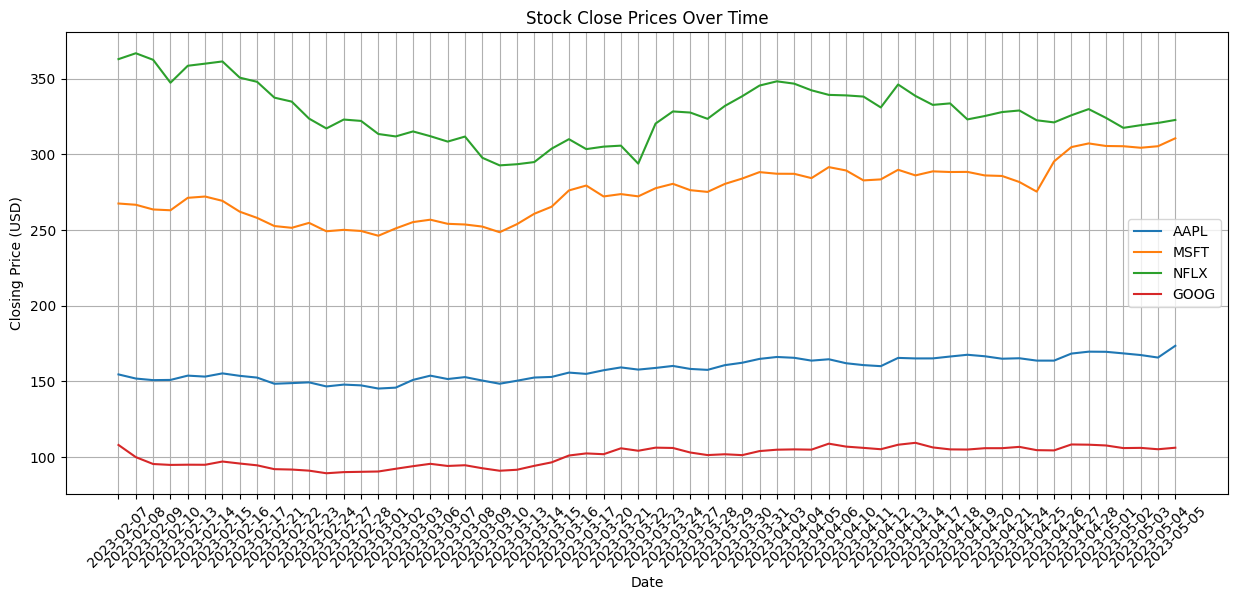

In [6]:
# Step 4: Plot Close Prices for All Companies
plt.figure(figsize=(15,6))
for Ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == Ticker]
    plt.plot(subset['Date'], subset['Close'], label=Ticker)

plt.legend()
plt.title('Stock Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Step 5: Calculate Moving Average and Volatility

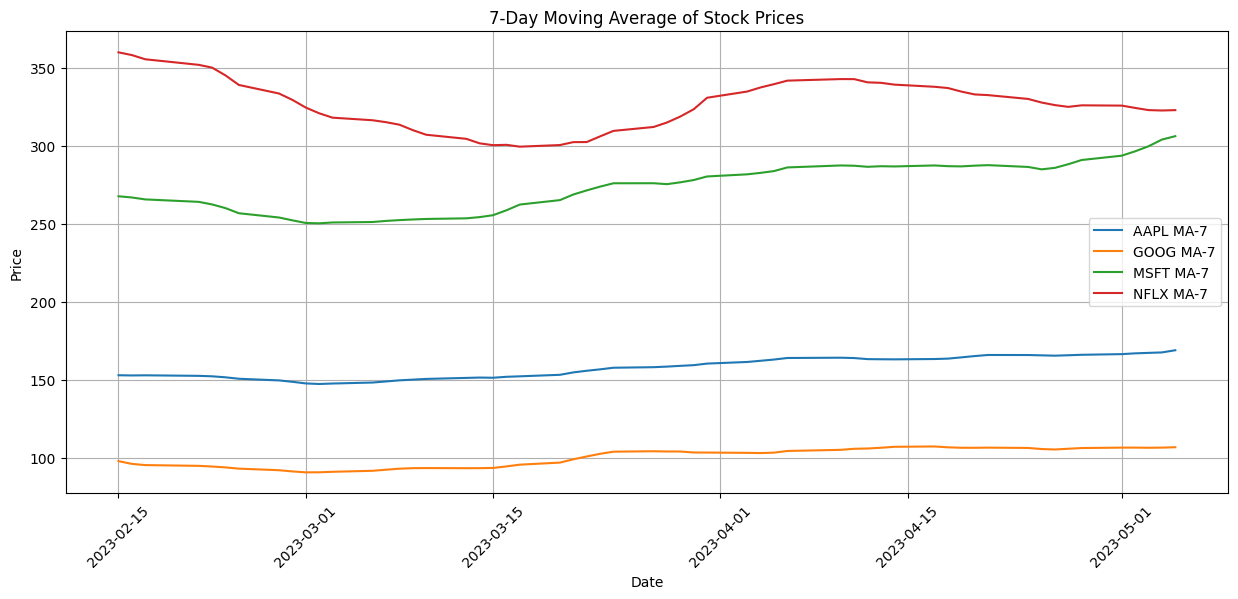

In [8]:
# Step 5: Calculate Moving Average and Volatility
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Ticker', 'Date'], inplace=True)

# Calculate moving average and volatility (rolling std deviation)
df['MA_7'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=7).mean())
df['Volatility_7'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=7).std())

# Plot moving averages
plt.figure(figsize=(15,6))
for Ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == Ticker]
    plt.plot(subset['Date'], subset['MA_7'], label=f'{Ticker} MA-7')

plt.legend()
plt.title('7-Day Moving Average of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


### # Step 6: Correlation Analysis

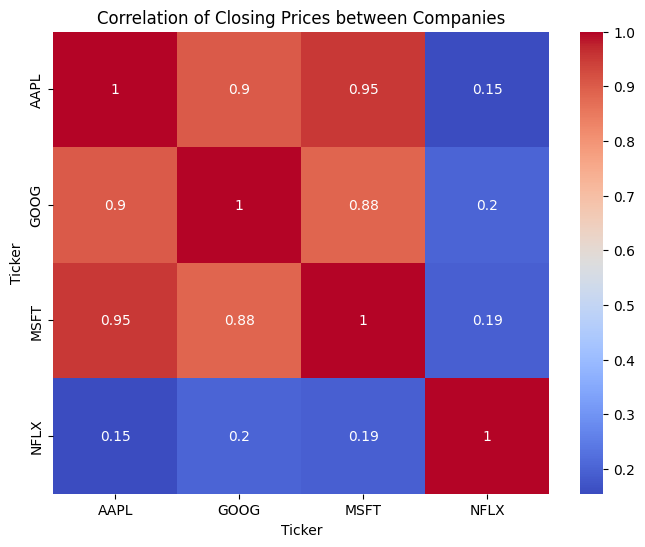

In [9]:
# Step 6: Correlation Analysis
# Pivot table to get stocks in columns for correlation
pivot_close = df.pivot(index='Date', columns='Ticker', values='Close')
correlation = pivot_close.corr()

plt.figure(figsize=(8,6))
sb.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation of Closing Prices between Companies')
plt.show()


### Step 7: Feature Engineering

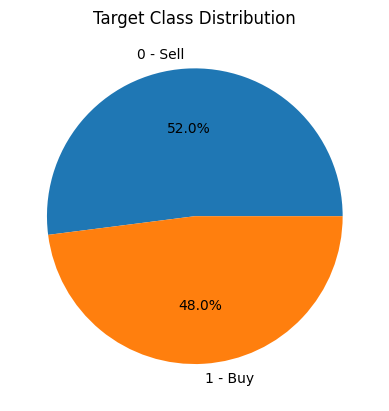

In [10]:
# Step 7: Feature Engineering
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df['is_quarter_end'] = df['Date'].dt.month % 3 == 0

# Pie chart for target class balance
plt.pie(df['target'].value_counts(), labels=['0 - Sell', '1 - Buy'], autopct='%1.1f%%')
plt.title('Target Class Distribution')
plt.show()


### Step 8: Prepare Features and Target

In [11]:
# Step 8: Prepare Features and Target
features = df[['open-close', 'low-high', 'is_quarter_end']].fillna(0)
target = df['target']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, target, test_size=0.1, random_state=42
)


### Step 9: Model Training and Evaluation


LogisticRegression Performance:
Training ROC-AUC: 0.6241919844861021
Testing ROC-AUC: 0.6333333333333333


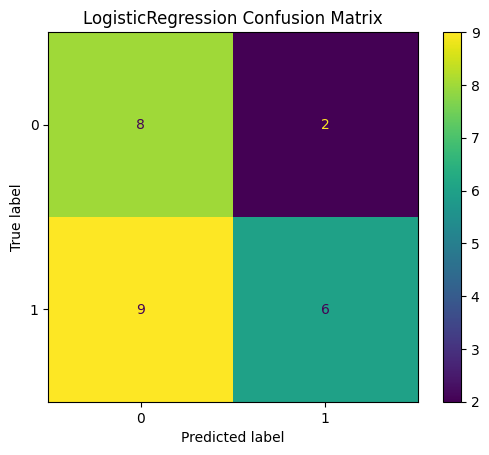


SVC Performance:
Training ROC-AUC: 0.690530058177117
Testing ROC-AUC: 0.5599999999999999


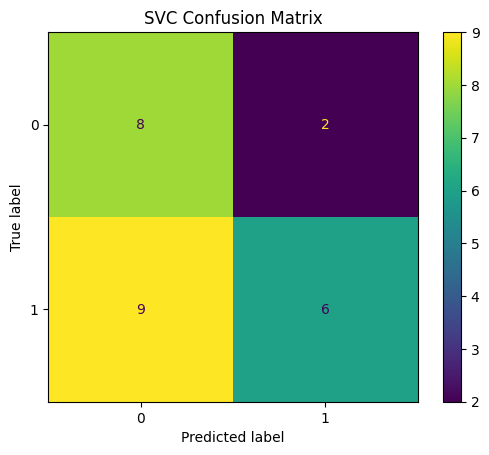


XGBClassifier Performance:
Training ROC-AUC: 1.0
Testing ROC-AUC: 0.4133333333333334


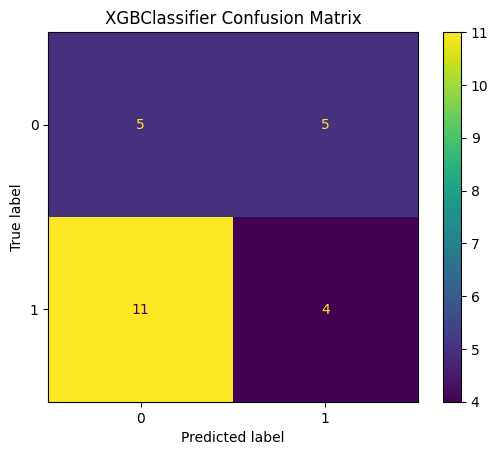

In [12]:
# Step 9: Model Training and Evaluation
models = [
    LogisticRegression(),
    SVC(kernel='poly', probability=True),
    XGBClassifier()
]

for model in models:
    model.fit(X_train, y_train)
    print(f'\n{model.__class__.__name__} Performance:')
    print('Training ROC-AUC:', metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    print('Testing ROC-AUC:', metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.show()
